Use kernel `papi-advanced`

## AI: Machine Learning & Deep Learning

In this lesson, we will explore how to apply machine learning (ML) methods to image analysis. 


---

### Machine Learning

In classical approach (what we did so far), we write explicit rules ourselves (processing steps with hard-coded parameters, fixed thresholds, flexible methods like Otsu’s method for algorithmical parameters determinations).

In ML, you feed in data and the **the rules are learned automatically from data**. The model adjusts its internal parameters to minimize an error (loss) between its predictions and the desired outcome, typically using an optimization procedure.

- *Supervised learning*: The model is trained on examples with known correct answers.
    - Example: You have images of cells and known (ground-truth) labels “these are dividing” and “these are not.” The model learns to tell them apart.
- *Unsupervised learning*: No labels provided. The model looks for structure or groups/clusters.
    - Example: Cells may be grouped based on similarities in shape or intensity without assigning biological meaning to the groups.


**Classical ML**: Relies on hand-selected features (e.g., area, intensity, texture) defined by the user. Algorithms such as Random Forests, Support Vector Machines, k-Means, or Logistic Regression then learn how to combine these features to make decisions.

**DL** (a specialized branch of ML): Learns features directly from raw data (like images or signals) removing the need for manual feature design. The model automatically discovers which patterns are most relevant for the task.

We will try two applications of ML:

**Object Classification:** 
In this approach, we first detect and measure all individual objects, and then train a ML model to classify each object into predefined categories — for example, distinguishing between Healthy and Apoptotic Cells.
We will use the **scikit-learn** library, which provides a range of classical machine learning algorithms such as Random Forests and Support Vector Machines.

**Pixel Classification (Segmentation)**: 
We teach the ML model to assign a class label to every single pixel in the image — for instance, separating Nucleus, Cytoplasm, and Background.
For this, we will use the **apoc** library.

---

#### Object classification - scikit learn

In this exercise, we will tackle a common problem in cell analysis: classifying cells into different populations based on their measured properties.

Simple scenario - we have 2 features (area and intensity) and annotated data (supervised learning).

We have a dataset of cells with their Area and Intensity measured. We will see from a scatter plot that there are likely separable into two distinct populations. Our goal is to find the line that best separates them.

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../data/cell_simple_measurements.csv')

# Let's visualize our starting data
plt.figure(figsize=(6, 4))
plt.scatter(df["Area"], df["Intensity"], c=df["Label"], cmap="coolwarm", alpha=0.6)
plt.xlabel("Area")
plt.ylabel("Intensity")
plt.show()

Let's try to separate these two populations with a simple line. 

A line is defined by the equation: y = a*x + b, which for us is:
```Intensity = slope * Area + intercept```

Do not worry to much about the code below. It uses `ipywidgets` library to create an interactive plot.

Your task now is to use the sliders associated with the plot to change the slope and intercept of the line. 

The goal is to find a line so that it gives the best possible separation between the two cell populations.

In [ ]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display


def interactive_classifier(df):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.scatter(df["Area"], df["Intensity"], c=df["Label"], cmap="coolwarm", alpha=0.6)
    ax.set_xlabel("Area")
    ax.set_ylabel("Intensity")
    ax.set_ylim(df['Intensity'].min() - 10, df['Intensity'].max() + 10)

    # Line
    x_vals = np.linspace(df["Area"].min(), df["Area"].max(), 400)
    line, = ax.plot(x_vals, np.zeros_like(x_vals), 'k--', lw=1)

    # Sliders
    slope_slider = widgets.FloatSlider(value=0, min=-3, max=3, step=0.05, description="slope")
    intercept_slider = widgets.FloatSlider(value=110, min=90, max=300, step=2, description="intercept")

    # Update function
    def update(change=None):
        slope = slope_slider.value
        intercept = intercept_slider.value
        line.set_ydata(slope * x_vals + intercept)
        ax.set_title(f'Intensity = {slope:.2f} * Area + {intercept:.1f}')
        fig.canvas.draw_idle()

    # Connect sliders
    slope_slider.observe(update, names='value')
    intercept_slider.observe(update, names='value')

    # Display widgets
    display(widgets.VBox([slope_slider, intercept_slider]))

    # Draw initial line
    update()


interactive_classifier(df)


Finding the best line by hand is subjective and can be time-demanding. Best let the ML model solve it for us! 

We will now use a Support Vector Machine (SVM), a classic machine learning algorithm, to find the optimal separating line automatically.

Workflow:
- Step 1: Prepare the data 
- Step 2: Train the machine learning model
- Step 3: Apply the model on other data

##### Step 1: Prepare the data 

The package we are using expects the data to be in specific format:
- X: A 2D array-like structure containing the features (our Area and Intensity columns) - can be DataFrame
- y: A 1D array-like structure containing the target labels (our Label column).

In [ ]:
# Prepare the feature matrix X
X = df[['Area', 'Intensity']]

# Prepare the target vector y
y = df['Label']

##### Step 2: Train the machine learning model

SVM is a machine learning method that tries to find the boundary (a line in 2D, a plane or hyperplane in higher dimensions) that best separates the data into different classes.
It does this by maximizing the margin — the distance between the boundary and the closest data points from each class (support vectors).

SVC (Support Vector Classifier) is a specific implementation of SVM used for classification tasks.

In our example, we use a SVC with a linear kernel, which means we ask the model to find a straight-line boundary between classes.

The command `model.fit(X, y)` is where the SVC learns this boundary from the data.

In [ ]:
# Create an instance of the linear SVM classifier
from sklearn.svm import SVC # Support Vector Classifier

# Prepare model
model = SVC(kernel='linear')

# Train the model on our data
model.fit(X, y)

The SVM decision boundary in this case is mathematically defined as:
`w1*feature1 + w2*feature2 + b = 0`

Weights (**w**) and bias (**b**) together define both the slope and the intercept of the separating line.

Each weight corresponds to one feature: w1 scales feature 1 (e.g., area), w2 scales feature 2 (e.g., intensity).

During training, the algorithm adjusts **w** and **b** to maximize the margin while correctly classifying the training data points.

Final weights and bias will be stored in our `model`.

In [ ]:
# Get the parameters

# Our model stores the boundary parameters in .coef_ and .intercept_
w = model.coef_[0] # a vector of weights [w₁, w₂] representing the contribution of each feature to the boundary
b = model.intercept_[0] # a scalar b representing the bias

# We can rearrange this to the familiar format: y = slope*x + intercept 
# w1*area + w2*intensity + b = 0    →     intensity = -(w1/w2)*area - b/w2

slope_ml = -w[0] / w[1]
intercept_ml = -b / w[1]

equation = f'Intensity = {slope_ml:.2f} * Area + {intercept_ml:.1f}'
print(equation)

Let's plot the decision boundary.

- In order to visualize lines in plots, we must generate a number of `x` values and compute the corresponding `y` values:
    - Code below generates 100 values linearly distributed between the minimum and maximum of Area values
        - `x_vals = np.linspace(df['Area'].min(), df['Area'].max(), 100)`
    - Then we use the equation to compute vector of corresponding y values.
        - `y_vals = slope_ml * x_vals + intercept_ml`

In [ ]:
%matplotlib inline
plt.close('all')
 
# Plot 
x_vals = np.linspace(df['Area'].min(), df['Area'].max(), 100)
y_vals = slope_ml * x_vals + intercept_ml

plt.figure(figsize=(6, 4))
plt.scatter(df["Area"], df["Intensity"], c=df["Label"], cmap="coolwarm", alpha=0.6)
plt.plot(x_vals, y_vals, color='black', linestyle=':', linewidth=2, label='SVM Decision Boundary')
plt.xlabel("Area")
plt.ylabel("Intensity")
plt.legend()
plt.show()

##### Step 3: Apply the model on other data

We will now read new measurements and classify them with help of our model. 

To apply our classifier model, we again need to prepare data. This time we only need the feature matrix - X.

We apply the model to get prediction simply with `model.predict(X)`.

In [ ]:
# Apply model to classify new data

df_new = pd.read_csv('../data/cell_simple_measurements2.csv')

X_new = df_new[['Area', 'Intensity']]

# Use the .predict() method on the trained model
new_predictions = model.predict(X_new)

Predictions are returned as an array with one entry for each row in the input feature matrix X_new.

We can easily add them to our dataframe as a new column.

In [ ]:
# Add these predictions as a new column in our new DataFrame for easy analysis and plotting
df_new['Predicted_Label'] = new_predictions

df_new.head()

Plot the result of our classification together with the decision boundary. 

In [ ]:
# Generate x values based on the new data's Area range
x_vals_new = np.linspace(df_new['Area'].min(), df_new['Area'].max(), 100)
# Compute corresponding y values using the trained model's slope and intercept
y_vals_new = slope_ml * x_vals_new + intercept_ml


# Plot data before and after classification 
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- Left Plot: Before Classification ---
axes[0].scatter(df_new["Area"], df_new["Intensity"], alpha=0.6)
axes[0].set_title("Before Classification")

# --- Right Plot: After Classification ---
axes[1].scatter(df_new["Area"], df_new["Intensity"], c=df_new["Predicted_Label"], cmap="coolwarm", alpha=0.6)
axes[1].plot(x_vals_new, y_vals_new, color="black", linestyle="--", label="Decision Boundary")
axes[1].set_title("After Classification")
axes[1].legend()

plt.show()


#### Classifying Real-World Cell Data

In our previous example, the two classes could be clearly separated using only two features. Real-world biological data is often much more complex.

More realistic scenarios:

- **High-dimensional feature space:** We often measure dozens of properties for each cell (area, intensity, perimeter, shape descriptors, texture metrics..). This results in a "high-dimensional" feature space that cannot be visualized directly.

- **Unknown feature importance:** It is usually unclear which features — or combinations of features — are actually informative for separating cell populations.

- **Non-linear separability:** The relationship between features and class labels is often complex and cannot be captured by a simple linear decision boundary.

To handle these challenges, we use more flexible machine learning models that can capture complex feature interactions.

---

**The Random Forest Classifier**

For complex feature-based data, a commonly used and robust choice is the Random Forest classifier.

Rather than learning a single decision rule, a Random Forest builds many simple decision trees. Each tree is trained on a random subset of the data and a random subset of features.
During prediction, all trees contribute a vote, and the final class is determined by majority voting.

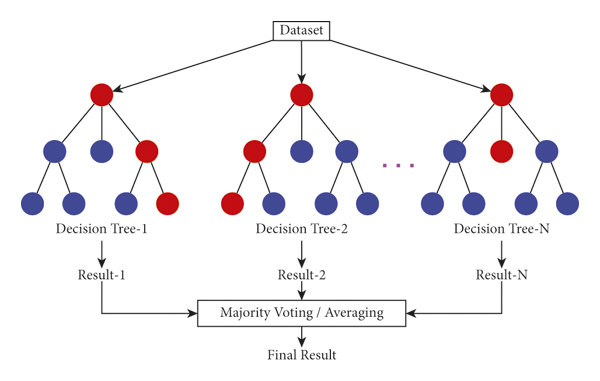


---

##### --- Exercise: Classifying Cells with RandomForest model ---

You are given two datasets (as Pandas DataFrames) containing multiple features (shape, size, intensity) calculated by skimage.regionprops.
- **ground_truth_df**: A table of measurements for 100 cells that have been expertly annotated by a biologist as either "Healthy" or "Cancer". This is your training data.
- **unannotated_df**: A larger table of measurements for 500 new cells from a different experiment. Your goal is to predict which of these are cancerous.

Your task:
1. Read DataFrames from csv files and explore the training data.
    - Let's use seaborn.pairplot to see the relationships between all our features, colored by the ground truth label.
    - ```python sns.pairplot(ground_truth_df, hue='label')```

2. Train a RandomForest Classifier on the ground_truth_df.
    - extract the feature matrix (as `X_train`) and labels (as `y_train`)
    - load the model and optionaly set parameters (function `RandomForestClassifier()`)
        - use `help()` to investigate the function and inquiry about its parameters
        - set number of decision trees to 200
        - set `random_state` to any number - find out what is its role
        - set argument `oob_score` as `True` to calculate out-of-bag (OOB) accuracy
    - use `.fit` to train the model (`model.fit(X_train, y_train)`)
    - print the oob accuracy score (`model.oob_score_`)

3. Apply the trained model to predict the class for every cell in unannotated_df.
    - Visualize the classification on the new data with seaborn pairplot (do not forget to add predictions to the unannotated_df to use it as hue argument)

4. Determine which features the model found the most important.
    - use `model.feature_importances_` to get importance scores (the order is same as the order of features given to model)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

GT_df_path = '../data/ml_ground_truth_cells.csv'
U_df_path = '../data/ml_unannotated_cells.csv'


<details>
<summary>Click to see the example solution</summary>

```python
# EXAMPLE SOLUTION

import seaborn as sns

# --- Read dataframes and make pairplot ---
ground_truth_df = pd.read_csv(GT_df_path)
unannotated_df = pd.read_csv(U_df_path)

print(ground_truth_df.head(n=3), '\n') # optionally check data
print(unannotated_df.head(n=3), '\n') # optionally check data

# Create a pairplot with seaborn
sns.pairplot(ground_truth_df, hue='label', palette='bwr')
plt.show()

# --- Prepare the training data ---
# Extract wanted columns 
feature_columns = [col for col in ground_truth_df.columns if col != 'label']
X_train = ground_truth_df[feature_columns]
# The 'label' column is what we want to predict
y_train = ground_truth_df['label']


# --- Initialize and train the Random Forest ---
# `n_estimators` is the number of decision trees in the forest
# `random_state` ensures that the results are areproducible by controling the randomness
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, oob_score=True)
rf_model.fit(X_train, y_train)
print("Random Forest model training complete.")
# out-of-bag accuracy of the model
print('out-of-bag accuracy: ', rf_model.oob_score_)


# --- Make predictions on other DataFrame ---
# Prepare the unannotated data for prediction
# It's crucial that we use the same feature columns and in the same order
X_unannotated = unannotated_df[feature_columns]

# Predict
predictions = rf_model.predict(X_unannotated)

# Add the predictions as a new column to our unannotated DataFrame
unannotated_df['predicted_label'] = predictions

# Visualize results
sns.pairplot(unannotated_df, hue='predicted_label', palette='bwr') 
plt.show()

# --- Determine the feature importances ---
# We could guess from the pairplot, that 'mean_intensity_ch2' seems to be the biggest driver
print('Feature importances')
importances = rf_model.feature_importances_
for feature, importance in zip(feature_columns, importances):
    print(f"{feature}: {importance:.3f}")

# Optional: bar plot
sns.barplot(x=importances, y=feature_columns)
plt.title("Feature Importances")
plt.show()
```

---

### Pixel classification (semantic segmentation)

We now move to pixel classification. This approach is useful for segmenting complex images where simple thresholding is insufficient.

How does this relate to object classification?

- Object classification operates on a table of features, where each row represents one object. The input is a feature DataFrame, and the output is a predicted class for each object.
- Pixel classification also operates on feature vectors, but here each row corresponds to a single pixel. Features are computed per pixel (often including local neighborhood information), and predictions are mapped back to form a label image.

In this exercise, we will create training labels interactively using Napari, which allows us to manually annotate example pixels by `painting` class labels. 

**Segmenting a DIC Image**

We will work with a sample transmitted-light image (DIC) containing roundish cells.
Separating these cells using traditional thresholding methods is very difficult, since each cell contains both bright and dark regions.

The Machine learning approach:
1. **Annotation**: 

    We begin by manually labeling a small number of pixels for each class. In this example, we define two classes: foreground (cells) and background.
2. **Feature Selection**: 

    Next, we define the image features that will be used for classification. These are pixel-level features, typically derived from filtered versions of the image, such as Gaussian smoothing, difference of Gaussians, or other filters that emphasize local structure and texture.
3. **Training**: 

    A classifier (such as Random Forest) learns the relationship between the extracted image features and the annotated class labels. During training, the model determines decision rules that best separate foreground and background pixels based on these features.
4. **Prediction**: 

    The trained classifier tis then applied to the full image to assign a class label to every pixel, producing a semantic segmentation. It can can also be applied to new, unseen images acquired under similar conditions.

Load image and inspect its properties

In [ ]:
from skimage import io

image_path = "../data/cho08.png"
image = io.imread(image_path)
print('image shape: ', image.shape, '\ndtype: ', image.dtype)

In [ ]:
plt.imshow(image, cmap='gray')

In [ ]:
# plot image histogram

plt.hist(image.ravel(), bins=256)
plt.show()

We will open a **napari** viewer and add our image to it. 

We will also create an empty "Labels" layer, which will be used to paint annotations directly in the GUI.

In [ ]:
import napari 

# Launch the Napari viewer
viewer = napari.Viewer()

# Add the image to the viewer
viewer.add_image(image, name='Cell Image')

# Create an empty label array (same shape as the image)
# The label layer will store manual annotations (e.g., foreground/background)
# Note: labels must be integer type
annotations_layer = viewer.add_labels(np.zeros(image.shape, dtype=np.uint32), name='Annotations')

**Annotation**

Now, go to the **napari** window that popped up. This is an interactive step.

*Instructions:*
- Select the Annotations layer in the layer list.
- In the layer controls panel, select the paint brush tool.
- Set the label number to 1. Use the paintbrush to paint a few small, representative regions of the background.
- Change the label number to 2. Paint over a few pixels of the cells. 

    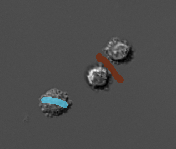

**Retrieve Annotations**

Once finished, we read the modified label array back to notebok.

In [ ]:
# FOR RE-RUN 1
# Retrieve data from the manually painted annotation layer
ground_truth_labels = viewer.layers['Annotations'].data

# Check if we have labels for 2 classes
# Label '0' represents unlabeled pixels and will be ignored by the classifier
unique_labels = np.unique(ground_truth_labels)
print(f"Labels found in our annotations: {unique_labels}")


**Select features and train the classifier**

We need to tell the classifier what kind of features to compute for each pixel. In `apoc` library, this is done by providing a *feature string* that defines a sequence of image processing operations applied to the image. 

Based on these computed features and the annotated pixels, the classifier learns how to distinguish between different regions in the image.

Typical features include image filters such as **Gaussian blur**, **Laplacian**, or **edge detectors (Sobel)**, which capture variations in intensity, texture, and structure. Features can also be combined—for example, applying a Sobel filter to a Gaussian-smoothed image—to emphasize specific patterns.

Using different sigma values or kernel sizes allows the classifier to respond to structures at different spatial scales.

In [ ]:
# FOR RE-RUN 2
# Now, we train our pixel classifier
import apoc

# Define the features. We'll use a combination of blur and edge detection.
# This gives the classifier information about local intensity and texture.
# Sigma is set to 2
feature_definition = "gaussian_blur=2 sobel_of_gaussian_blur=2"

# Create a Pixel Classifier object.
# Apoc runs a RandomForrest algorithm, so you can define for example number of decision trees
# 'opencl_filename' defines the filename for saving the trained model.
classifier = apoc.PixelClassifier(opencl_filename="first_pixel_classifier.cl")

# Train the classifier.
# This may take a few seconds depending on image size and number of features.
classifier.train(features=feature_definition, ground_truth=ground_truth_labels, image=image)

print("\nClassifier training complete.")

**Prediction**

We will use the trained model to segment our input image.

The prediction is performed using:
```python
classifier.predict(features, image)
```
We specify the image to be segmented (i.e., the pixels to be classified) and provide the same feature set that was used during training.

The result will be a new label image where every pixel is assigned to either class 1 (background) or class 2 (cells).

In [ ]:
# FOR RE-RUN 3
# Predict the class for every pixel
prediction = classifier.predict(features=feature_definition, image=image)

# Add the prediction as a new labels layer in Napari
viewer.add_labels(prediction, name='Segmentation')

**Refinement**

There are two main ways to improve the classifier:

- Annotate more data
- Modify the input feature set

Try to go back to **napari** and annotate more pixels in **Annotation** layer. Then re-run the code cells to retrieve Annotation layer data, train classifier and run prediction (code cells that start with comment # FOR RE-RUN).

This iterative process is usually applied to produce better segmentation results.

**Inspect features**

You can visualize the features that will be used. 

In this example, we define a set of features and apply them to our image.

In [ ]:
# List of features
feature_list = [
    'gaussian_blur=2',
    'gaussian_blur=6',
    'difference_of_gaussian=2',
    'sobel_of_gaussian_blur=2',
    'median_box=2',
]

print('List of features\n', feature_list)

# Convert list to space-separated string for APOC
features = ' '.join(feature_list)
print('List converted to string:\n', features)

In [ ]:
# Feed the feature string to apoc to generate feature stack
feature_stack = apoc.generate_feature_stack(image, features)


# Number of features
n_features = len(feature_stack)

# Plot all generated feature maps
fig, axes = plt.subplots(n_features, 1, figsize=(4, 2*n_features))

for ax, feature, name in zip(axes, feature_stack, feature_list):
    ax.imshow(feature, cmap='gray')
    ax.set_title(f'{name}')
    ax.axis('off')
    
plt.tight_layout()
plt.show()

**Predefined feature sets**

APOC provides several predefined feature sets that you can use out of the box. They are designed for example for objects of different sizes. [More info.](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/20a_pixel_classification/feature_stacks.html?highlight=predefined)

Using a predefined feature set can help you get started quickly, especially if you’re unsure which features will work best for your images.

In [ ]:
# We can also use predefined feature sets
features = apoc.PredefinedFeatureSet.medium_quick.value
print(features)

**Train classifier with pre-defined feature set**

We already have our Annotation layer, it is super easy now to train new classifier with different feature set.

In [ ]:
# Train new classifier and predict segmentation
classifier = apoc.PixelClassifier(opencl_filename="second_pixel_classifier.cl")
classifier.train(features=features, ground_truth=ground_truth_labels, image=image)
prediction = classifier.predict(features=features, image=image)

plt.imshow(prediction, cmap='gray')

You can use the code below to print all available predefined feature sets.


```python
import apoc

for featset in apoc.PredefinedFeatureSet:
    print(f'{featset.name} -- feature set: {featset.value}\n')
```

**Further analysis**

We classified cells and background, but both have a label value > 0.


To perform instance segmentation (i.e., extract individual cells), we need to further process the resulting labels.

Ee can create a binary mask for the cells simply by thresholding.

In [ ]:
# Thresholding
cells_mask = prediction>1 # in our case, the background should have label 1

Let's count the number objects.

In [ ]:
from skimage import measure
cells_labels = measure.label(cells_mask) # instance segmentation based on connected components

# Get number of unique objects
# Variant A
# By getting max label value (can be incorrect when missing intermediate labels)
number_of_objects = cells_labels.max() 
print("cell count:", number_of_objects) 

# Variant B
# By counting unique lables
unique_labels = np.unique(cells_labels)
unique_labels = unique_labels[unique_labels != 0] # Exclude the background label (0)
number_of_objects = len(unique_labels)
print("cell count:", number_of_objects)

# Add labels to Napari
viewer.add_labels(cells_labels)

**Alternative: APOC Object Segmenter**

APOC also provides an Object Segmenter, which allows you to perform instance segmentation directly. This is an alternative to using classifier combined with connected components labeling (skimage.measure.label) on a binary mask. 

The workflow is very similar to pixel classification: you select features, build and train a classifier, and then predict labels for all objects in the image.

In [ ]:
# Object segmenter

# Select a predefined feature set
features = apoc.PredefinedFeatureSet.medium_quick.value

# Prepare the model - this time ObjectSegmenter
segmenter = apoc.ObjectSegmenter(opencl_filename='object_segmenter.cl', positive_class_identifier=2)

# Train the model
segmenter.train(features, ground_truth_labels, image)

# Predict
segmentation_result = segmenter.predict(features=features, image=image)
plt.imshow(segmentation_result)

---

##### ---  Exercise: Train a Pixel Classifier / Object Segmenter on a time-lapse image

**Steps:**

1. Load the image `mouse_SC.tif` from `data` folder and check its dimensions.
   * Extract the first frame and store it in a new variable.
2. Create a separate *napari* *viewer* instance (e.g. viewer2).
3. Send the extracted frame to *napari*.
   * Crate an empty labels layer (either from the notebook or directly in the GUI).
4. In the Labels layer make annotations for pixels inside cells and background (different labels for different classes).
5. Pull the annotation layer back into the notebook and store it as `annotations`.
6. Use `annotations` and the extracted frame image to train an **APOC PixelClassifier** or **ObjectSegmenter**.
    - Try to set the features to get good-loking segmentation results.
    - You can iteratively adjust features after prediction.
    - Example solution uses `apoc.PredefinedFeatureSet.medium_quick.value`.
7. Predict on the single frame to verify that the classifier has learned to segment cells.
8. Predict on all other frames of the timelapse. 
9. Send both the full image stack and the predicted segmentation stack to *napari* to inspect the results.
10. Count the number of detected objects per frame.
    - *Note:* If you used *PixelClassifier*, convert the predicted mask to a labeled image using `skimage.measure.label`.
11. Plot cell counts over time.

In [ ]:
# Your code here


<details>
<summary>Click to see the example solution - steps 1-4</summary>

```python
# EXAMPLE SOLUTION

# --- Load image and check shape ---
image_stack = io.imread('../data/mouse_SC.tif')
print("Image shape:", image_stack.shape)

# --- Extract first timepoint and send to Napari ---
first_frame = image_stack[0]

viewer2 = napari.Viewer()
viewer2.add_image(first_frame, name='First Frame')

# Add empty annotation layer
annotations = viewer2.add_labels(np.zeros_like(first_frame, dtype=np.uint32), name='Annotations')

# --- Annotate in Napari GUI ---
# Manually paint a few cells and background
#
#
```
</details>

<details>
<summary>Click to see the example solution - steps 5 onward </summary>

```python
# --- Pull annotation layer back ---
annotations = viewer2.layers['Annotations'].data

# --- Train PixelClassifier ---
features = apoc.PredefinedFeatureSet.medium_quick.value
# set positive_class_identifier according to your labeling
clf = apoc.ObjectSegmenter(opencl_filename='exercise_segmenter.cl', positive_class_identifier=2)
clf.train(features=features, ground_truth=annotations, image=first_frame)

# --- Predict on first frame ---
predicted_mask = clf.predict(features=features, image=first_frame)
viewer2.add_labels(predicted_mask, name='Predicted Mask')


# --- Predict on all timepoints ---
segmentation_stack = []
for t in range(image_stack.shape[0]):
    pred = clf.predict(features=features, image=image_stack[t,:,:])
    segmentation_stack.append(pred)
segmentation_stack = np.array(segmentation_stack)

# --- Send the stacks to Napari
viewer2.add_image(image_stack, name='Image Stack')
viewer2.add_labels(segmentation_stack, name='Segmentation Stack')


# --- Count objects per slice ---
cell_counts = []
for t in range(segmentation_stack.shape[0]):
    labeled = measure.label(segmentation_stack[t] > 1)  # threshold background label 1
    cell_counts.append(labeled.max())

# --- Plot cell count over time ---
plt.figure(figsize=(6,4))
plt.plot(cell_counts, marker='o', linestyle='None')
plt.xlabel('Timepoint')
plt.ylabel('Number of cells')
plt.show()

# --- (alternative): Plot with Seaborn regression ---
import seaborn as sns
timepoints = np.arange(len(cell_counts))

plt.figure(figsize=(6,4))
sns.regplot(x=timepoints, y=cell_counts, marker='o', ci=None,)
plt.xlabel('Timepoint')
plt.ylabel('Number of cells')
plt.show()

```
</details>

#### Apoc as napari plugin

By the way, `apoc` exists as a *napari* plugin. With it, you can do all steps (labeling, feature selection, training, inference) direcly inside *napari* GUI.

[link](https://github.com/haesleinhuepf/napari-accelerated-pixel-and-object-classification)

---

### USE CASE: Tracking

In the previous exercise we have segmented cells in frames of a timelapse. Lets track them!

**Tracking in biology**

Tracking is a process of identifying and following individual objects (like cells, nuclei, or vesicles) through a sequence of images over time.

Tracking is a usually a two-step process:
- Detection: In every single frame of the movie, find all the objects of interest. 
    We just learned how to do this with our machine learning segmenter.
- Linking: Connect the detection of an object in one frame to the same object in the next frames to form a trajectory.

Example Python packages for tracking:

- **[trackpy](https://soft-matter.github.io/trackpy/v0.7/)**
    
    Implements a simple and robust linking algorithm.
    Easy to configure for basic timelapse tracking tasks.

- **[btrack](https://btrack.readthedocs.io/en/latest/)** (Bayesian Tracker)

    A more advanced, probabilistic approach.
    Can handle complex events like splitting and merging of objects.

- **[Ultrack](https://github.com/royerlab/ultrack)**

    Scalable cell tracking method designed to address the challenges of tracking cells across 2D, 3D, and multichannel timelapse recordings, especially in complex and crowded tissues.


**Workflow**

We will now track cells in our timelapse stack using `trackpy`.

1. Detect (segment) objects (already done that).
    - You can use the segmentation you just created, or load provided ground truth (perfect) segmentations.
2. Get object centroids - with `skimage.measure.region_props`.
3. Link detections across frames - with `trackpy`.
4. Visualize tracks in `napari`.

Load image and labels

In [ ]:
# Read labels from file
labels_path = r'../data/mouse_SC_labels.tif'
labels = io.imread(labels_path) # or set labels as your ML result

# Read image
image_path = r'../data/mouse_SC.tif'
image_stack = io.imread(image_path)

# Display labels over image
import stackview
stackview.blend(image_stack, labels, colormap2='nipy_spectral')

To link cells across a time-lapse sequence, we compute the centroid of each detected object and store these coordinates in a DataFrame.

In [ ]:
# We need to process our stack by slice (frame)
# Otherwise skimages' regionprops_table would evaluate objects in 3D (all labels with same ID would be connected)

all_detections = [] # create an empy list to store properties tables per frame

for frame_index, single_frame_labels in enumerate(labels):
    if single_frame_labels.max() == 0: # avoid empty frames
        continue

    props = measure.regionprops_table(
        label_image = single_frame_labels,
        properties = ('label', 'centroid', 'area') # detect centroid and measure area
    )
    frame_df = pd.DataFrame(props) # create DataFrame from dictionary
    frame_df['frame'] = frame_index # add column 'frame' to store number of current frame

    all_detections.append(frame_df)

detections_df = pd.concat(all_detections, ignore_index=True) # merge all DataFrames into one

detections_df.head(3)

In [ ]:
# Formatting for trackpy
# `trackpy` requires specific column names: 'x', 'y', and 'frame'.
detections_df = detections_df.rename(columns={'centroid-0': 'y', 'centroid-1': 'x'}) # rename columns

detections_df.head(3)

**Linking detections with trackpy**

Next, we use `trackpy.link()` to connect detected objects across frames into continuous trajectories.

We must must specify a maximum distance (`search_range`) that an object is allowed to move between consecutive frames.

We also set the `memory` parameter - the number of frames an object can temporarily disappear and still be linked to the same trajectory. This can happen for example due to disappearing from the field of view or missed segmentation. 

In [ ]:
# Use trackpy to link detections into trajectories

import trackpy as tp 

# search_range = max distance a cell can travel between frames (pixels)
# memory = number of consecutive frames an object can be missing in trajectory
tracks_df = tp.link(detections_df, search_range=100, memory=3)

# We will get back a pandas DataFrame with extra column
tracks_df

**Visualize tracks in napari**

Create a napari viewer and add image stack and label stack.

In [ ]:
viewer = napari.Viewer()

viewer.add_image(image_stack, name='image')
viewer.add_labels(labels, name='labels')

Add tracks to visualize them on top of our data.

In [ ]:
# Add the tracks. 
# napari's `.add_tracks()` can work with pandas DataFrames!
track_data = tracks_df[['particle', 'frame', 'y', 'x']]
viewer.add_tracks(track_data, name='Tracks')

You can play with the Track layer controls in napari to adjust the visualization.

In [ ]:
napari.utils.nbscreenshot(viewer, canvas_only=True)

<br><br>

---

### Deep Learning Fundamentals

Deep Learning in the context of Machine Learning

In the previous ML session, we relied on feature engineering: we manually selected object-level measurements (such as area, eccentricity, and intensity) or defined pixel-level features using image filters. In both cases, we explicitly specified which aspects of the data the algorithm was allowed to use.

Deep Learning is a subfield of machine learning that shifts much of this responsibility to the model itself. Instead of operating on predefined features, deep learning models typicaly use multi-layer neural networks to learn useful representations directly from raw data. 

During training, the network automatically constructs increasingly informative features that are optimized for the task at hand. This process is known as representation learning and makes it possible to capture complex patterns.

#### Brief introduction to deep neural networks, CNN and U-nets

A neural network (NN) consists of layers of neurons (nodes) that transform input data into outputs. Each neuron computes a weighted sum of its inputs, adds a bias, and applies a activation function. Activation function introduces non-linearity, enabling the network to learn complex patterns.

Example: XOR problem

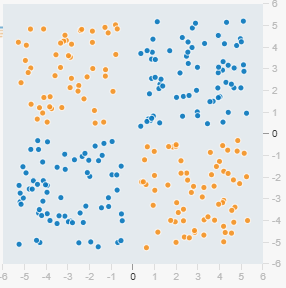

A simple linear model cannot separate these classes. A small neural network with one hidden layer and non-linear activation can learn the correct mapping.

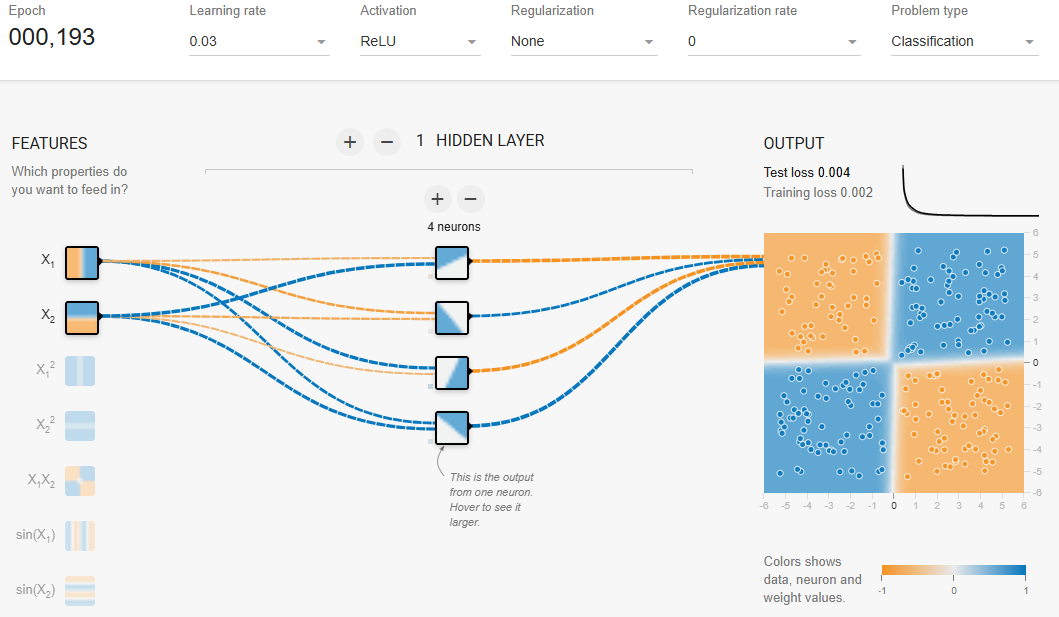

You can build your own networks in Python using libraries such as `tensorflow` or `pytorch`.

For quick experimentation without the need for installation, try the [TensorFlow Playground](https://playground.tensorflow.org/) to experiment with network design.


**Encoder-Decoder architectures**

For images, specialized NN architectures are more effective than fully connected networks because they exploit spatial structure. (A fully connected network treats every input pixel independently: it does not know which pixels are neighbors.)

An encoder-decoder is a general neural network design used for tasks where the output has a similar structure to the input, such as image segmentation, reconstruction, or denoising. (For classification tasks, the decoder is usually omitted: the encoder outputs a feature vector that is mapped to class labels.)

General principle:
- Input
    - The raw data (e.g., an image).
- Encoder (contracting path)
    - The encoder gradually compresses the input into a compact latent representation. 
    - Each layer extracts features of increasing complexity.
    - Compression is often done using convolutions + pooling (CNNs) or patch embeddings + attention (ViTs).
    - CNN = Convolutional Neural Networks, ViT = Vision Transformers
- Decoder (expanding path)
    - The decoder takes the latent representation and gradually upsamples it to reconstruct an output that has the same spatial dimensions as the input.
    - In CNNs, this is done with upsampling / transposed convolutions.
    - In ViTs, attention maps guide how patches are combined to reconstruct the output.
- Skip connections (optional but common)
    - Some encoder-decoder designs, like U-Net, merge features from encoder layers into the decoder at corresponding levels.
    - This preserves fine spatial details that might otherwise be lost during compression.


#### Instance Segmentation with Cellpose

**Cellpose** is a generalist, deep learning-based algorithm for segmentation of cells, nuclei, and similar biological structures. Robust across diverse microscopy images.

Cellpose 3.x:

- Provides several cell-expert models already trained and ready to use. In this lesson, we will use these pre-trained models and also fine-tune a model to improve performance on our specific data.
- U-Net–style CNNs, but with a tweak for instance segmentation.

Cellpose 4.x:

- The latest version (Cellpose-SAM), integrates the original cell-expert models with the Segment Anything Model (SAM). (uses a Vision Transformer (ViT) backbone instead of a U-Net).
- This approach is computationally heavier, especially on CPU-only systems.

**Load sample data**

In [ ]:
from skimage import data
import matplotlib.pyplot as plt
from skimage import io
# --- Load a challenging image of crowded nuclei ---
image_nuclei = data.human_mitosis()
print("Loaded nuclei image with shape:", image_nuclei.shape)
plt.imshow(image_nuclei, cmap='gray')
plt.axis('off')
plt.show()

**Initialize model**

We initialize the `Cellpose` model, specifying the `model_type='nuclei'` since our image contains nuclei.

In [ ]:
from cellpose import models, io

# Set up logging to see progress messages
io.logger_setup() 

# Initialize the pre-trained 'nuclei' model
model = models.Cellpose(model_type='nuclei')

**Apply the model**

We apply the model to our image using the `.eval()` method. All other arguments are optional. 

Cellpose can handle up to 3-channel images. In the `channels` argument: [0,0], the first number specifies used channel - (0 stands for projection of all channels). 
The second value specifies an optional nuclear channel to aid cytoplasm segmentation (here, 0 means none is used) - this work only with some models, such as `cyto`.

The pre-trained model returns four outputs:
- `masks`: An image where each detected object is assigned a unique ID.
- `flows`: A representation of the model's predicted gradients.
- `styles`: A vector representing the latent space of the image.
- `diams`: The estimated average diameter of the objects.

In [ ]:
# Run the model on the image. 'diameter=None' lets Cellpose estimate it.
mask, flow, style, diam = model.eval(image_nuclei, diameter=None, channels=[0,0])

Visualization

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Subplot 1: Original Image
axes[0].imshow(image_nuclei, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Subplot 2: Segmentation mask
axes[1].imshow(mask, cmap='nipy_spectral')
axes[1].set_title('Masks')
axes[1].axis('off')

# Subplot 3: Flow
axes[2].imshow(flow[0], cmap='viridis')
axes[2].set_title('Flow')
axes[2].axis('off')

# Subplot 4: Cell Probability Map
axes[3].imshow(flow[2], cmap='coolwarm')
axes[3].set_title('Cell Probability')
axes[3].axis('off')


plt.tight_layout()
plt.show()

##### --- Exercise: Cellpose testing ---

Segment image with `cyto3` model. 

Optionally explore how different **Cellpose parameters** affect cell segmentation. 

-   `diameter`: The estimated average diameter of objects (in pixels). If set incorrectly, it can lead to over- or under-segmentation.
-   `flow_threshold`: Maximum allowed error of the flows for each mask. Higher values results in more detected objects (but may include small debris or ill-shaped masks). Default is 0.4.

Your task:
1. Read the image from the given path.
2. Initialize the `cyto3` model from Cellpose.
3. Run model evaluation with default parameters to generate mask.
4. Count the number of detected objects and print it. 
   -*Hint: you can use `mask.max()` - number of detected cells corresponds to the maximum label value.*
5. Plot the image-mask overlay 
   - use Cellposes' `plot.mask_overlay(image, mask)` to create rgb overlay (you have to import the `plot` method first)
   - Plot rgb overlay with matplotlibs' imshow

Optional:
6. Test the parameters provided in lists.
   - Run model evaluation first for different diameters, then for different flow_thresholds.
   - For every run, count the detected objects and plot overlays. (You can package these 2 steps to a function.)

In [ ]:
test_image_path = '../data/small_image.tif'

diameters = [10,38,100]
flow_thresholds = [0.1, 1]

# Your code here


<details>
<summary>Click to see the example solution</summary>

```python
# EXAMPLE SOLUTION

# --- Load image and initialize model ---
test_image = io.imread(test_image_path)
model = models.Cellpose(model_type='cyto3')

# Run model with default parameters
mask, _, _, _ = model.eval(test_image)

# Count cells
n_cells = mask.max()
print('Number of detected objects:', n_cells)

# Plot rgb overlay
from cellpose import plot # load plto from cellpose
overlay = plot.mask_overlay(test_image, mask)
plt.imshow(overlay)
plt.axis('off')
plt.show()

# Optional step
# Define helper function
def count_and_plot(mask):
    print(f"Detected {mask.max()}")
    overlay = plot.mask_overlay(test_image, mask)
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()

# Run models
for d in diameters:
    mask, _, _, _ = model.eval(test_image, diameter=d)
    print('Diameter', d)
    count_and_plot(mask)

for f in flow_thresholds:
    mask, _, _, _ = model.eval(test_image, flow_threshold=f)
    print('FT', f)
    count_and_plot(mask)
```

##### Fine-Tuning

The pre-trained models are powerful, but not perfect. If you have a very specific or unusual cell type, you might need to fine-tune the model.

Fine-tuning allows you to adapt a pre-trained model to your specific data with a minimal amount of manual annotation, which is far more efficient than training a new model from scratch (the fine-tuning starts with pre-trained model weights and...).

The standard workflow can iterative:
1.  Run the pre-trained model on a small and representative set of your images to get preliminary masks.
2.  Load the images and the predicted masks into an annotation tool (like the **Cellpose GUI** or **napari**).
3.  Manually correct the errors made by the model (fix annotations). This is usually faster than drawing everything from scratch (but not always).
4.  Use the original images and your corrected masks to train (fine-tune) a new model, starting from the weights of the pre-trained model.

##### --- Exercise: Fine-tuning a Cellpose model with napari ---

1.  Segment the provided image using the pre-trained `cyto3` model.
2.  Open the image and the resulting mask in *napari*.
    - Use *napari's* label editing tools (paintbrush, eraser, fill bucket) to correct any segmentation errors.
    - *Hint: initialize napari window under a variable - e.g. with viewer = napari.Viewer()*
    - *Use `.add_image()` and `.add_labels()` to upload data to napari viewer - assign these layers to variables so you can access their data later.*
3.  Extract the refined mask data back into your notebook from the napari labels layer.
    - *Hint: If the labels layer is stored in a variable, you can access the mask data via variable_name.data*
4.  Train a fine-tuned model using the provided code (below example solution) and your corrected image–mask pair.
    - Update variable names as needed to match your notebook.

In [ ]:
train_image = io.imread('../data/t000.tif')

# Your code here for steps 1-3.

<details>
<summary>Click to see the example solution</summary>

```python
# Segment image with cellpose
model = models.Cellpose(model_type='cyto3')
train_mask, _, _, _ = model.eval(train_image)

# Send to Napari
import napari

viewer = napari.Viewer()
img_layer = viewer.add_image(train_image)
msk_layer = viewer.add_labels(train_mask)

# Manual refinement
# ...

# Pull mask
refined_mask = msk_layer.data
```

--- Step 4. - Training

Set correct variable names (yours) instead of `refined_mask`.

In [ ]:
# retrain a Cellpose model

# read training method
from cellpose import train

# initialize an input model
input_model = models.CellposeModel(model_type="cyto3")

# fine-tune the model
model_path, train_losses, test_losses = train.train_seg(input_model.net,
                            train_data=[train_image], # Note: We wrap our single image/mask in a list
                            train_labels=[refined_mask], # because the training function expects a list or stack of images.
                            channels=[0,0], normalize=True,
                            weight_decay=1e-4, SGD=True, learning_rate=0.1,
                            n_epochs=10, model_name="my_new_model")

**Apply the fine-tuned model**

In [ ]:
# Initialize a model from our custom-trained weights file
my_model = models.CellposeModel(model_type='./models/my_new_model')

# Run evaluation with the new model
# Note: Custom models return 3 outputs instead of 4 (no style vector)
new_mask, _, _ = my_model.eval(train_image, channels=[0,0])

Check the results. Again set proper variable name instead of refined_mask (your manualy corrected data).

In [ ]:
# Visualize the result
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(refined_mask, cmap='nipy_spectral')
axes[0].set_title('Ground Truth ~ manual')
axes[1].imshow(new_mask, cmap='nipy_spectral')
axes[1].set_title('Prediction from model')
for ax in axes:
    ax.axis('off')
plt.show()

#### Data augmentation

Data augmentation artificially increases the size and diversity of your training dataset by applying transformations such as rotation, flipping, scaling, or contrast changes.

To transform our image, we will use `scikit-image` library.

In [ ]:
from skimage import transform, exposure, util
import numpy as np

# rotate image and mask
angle = 90
img_rot = transform.rotate(train_image, angle, resize=True, preserve_range=True)
mask_rot = transform.rotate(refined_mask, angle, resize=True,
                            preserve_range=True, order=0)  # nearest-neighbor for masks

# flip image and mask (horizontal flip)
img_flip = np.fliplr(train_image)
mask_flip = np.fliplr(refined_mask)

# adjust contrast (keep GT mask unaffected)
p2, p98 = np.percentile(train_image, (2, 98))
img_contrast = exposure.rescale_intensity(train_image, in_range=(p2, p98))

# add noise (keep GT mask unaffected)
img_noise = util.random_noise(train_image, mode='gaussian', var=0.01)
img_noise = img_noise * train_image.max()  # rescale if original image is not [0,1]


# --- Store modified images and labels along original in lists
aug_images = [train_image, img_rot, img_flip, img_contrast, img_noise]
aug_masks = [refined_mask, mask_rot, mask_flip, refined_mask, refined_mask]

In [ ]:
# Display augmented dataset

n_images = len(aug_images)
fig, axes = plt.subplots(2, n_images, figsize=(12, 3))
for i in range(n_images):
    axes[0, i].imshow(aug_images[i], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Aug {i+1}")
    
    axes[1, i].imshow(aug_masks[i], cmap='nipy_spectral')
    axes[1, i].axis('off')
plt.show()

To use these data for fine-tuning, we coulde sTo use these augmented data for fine-tuning, we can simply run the following code, replacing the original training data with the augmented images and masks.

```python
# fine-tune the model with augmented training data
model_path, train_losses, test_losses = train.train_seg(input_model.net,
                            train_data=aug_images, # <----  list of augmented images
                            train_labels=aug_masks, # <---- list of corresponding masks
                            channels=[0,0], normalize=True,
                            weight_decay=1e-4, SGD=True, learning_rate=0.1,
                            n_epochs=10, model_name="augmented_model")
```

#### Object-based analysis

##### USE CASE: Cytoplasm-to-Nucleus Translocation

This example demonstrates how to measure the redistribution of a fluorescent marker between predefined compartments (e.g., cytoplasm and nucleus). 

It uses object segmentation and intensity ratio measurements to capture spatial relocalization.

**Workflow:**
1.  Segment cells.
2.  Segment nuclei.
3.  For each cell, define the cytoplasm as the area within the cell mask but outside the nucleus mask.
4.  Calculate the ratio of the mean intensity in the nucleus to the mean intensity in the cytoplasm for the protein of interest.
5.  Analyze the distribution of these ratios across the cell population.

In [ ]:
# Initialize models for cell and nuclei segmentation
model_cell = models.Cellpose(model_type='cyto3')
model_nuc = models.Cellpose(model_type='nuclei')

In [ ]:
# Load image from conditions: Treatment A.
image_A = io.imread('../data/cn_treatmentA.tif')     
print(image_A.shape)

# Extract channels
protein_channel_A = image_A[0,:,:]
nuclei_channel_A = image_A[1,:,:]

# Plot channels
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(protein_channel_A, cmap='gray')
ax[1].imshow(nuclei_channel_A, cmap='gray')
for a in ax:
    a.axis('off')
plt.show()

In [ ]:
# Perform segmentation
cell_mask_A,_,_,_ = model_cell.eval(protein_channel_A)
nuc_mask_A,_,_,_ = model_nuc.eval(nuclei_channel_A)

In [ ]:
# Create a binary mask for the cytoplasm of all cells
cell_binary_A = cell_mask_A > 0
nuc_binary_A = nuc_mask_A > 0
cyto_binary_A = cell_binary_A & ~nuc_binary_A # Logical AND NOT

In [ ]:
# Visualize the generated masks
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

axes[0].imshow(cell_mask_A, cmap='nipy_spectral')
axes[0].set_title('Cell Masks')

axes[1].imshow(nuc_mask_A, cmap='nipy_spectral')
axes[1].set_title('Nucleus Masks')

axes[2].imshow(cyto_binary_A, cmap='gray')
axes[2].set_title('Cytoplasm Mask')

for a in axes:
    a.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Or use other approach such as cellpose.plot

from cellpose import plot

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

overlay_cells = plot.mask_overlay(protein_channel_A, cell_mask_A)
axes[0].imshow(overlay_cells)
axes[0].set_title('Cell Masks')

overlay_nuc = plot.mask_overlay(protein_channel_A, nuc_mask_A)
axes[1].imshow(overlay_nuc)
axes[1].set_title('Nucleus Masks')

overlay_cyto = plot.mask_overlay(protein_channel_A, cyto_binary_A.astype(np.uint8))
axes[2].imshow(overlay_cyto)
axes[2].set_title('Cytoplasm Mask')

for a in axes:
    a.axis('off')
    
plt.tight_layout()
plt.show()


Global ratio - for the whole image

In [ ]:
# --- Compute global intensities ---
nuc_signal = protein_channel_A[nuc_binary_A].mean()
cyto_signal = protein_channel_A[cyto_binary_A].mean()

global_ratio = nuc_signal / cyto_signal

print(f"Global nuclear/cyto ratio = {global_ratio:.3f}")

Per cell ratio

Now we can measure the translocation ratio on a per-cell basis. 

We will iterate through each segmented cell, define its corresponding nuclear and cytoplasmic regions, and calculate the ratio.

In [ ]:
from skimage import measure 

def calculate_cn_ratios(cell_mask, nuc_mask, protein_channel):
    """Calculates the C/N ratio for each cell in a labeled mask."""
    results = []
    nuc_binary = nuc_mask > 0
    unique_labels = np.unique(cell_mask) # list of unique labels
    cell_labels = unique_labels[unique_labels != 0] # list of unique cell labels (without 0 for background)

    for cell_id in cell_labels: # for every cell

        # Extract the mask for the current cell
        single_cell_mask = (cell_mask == cell_id) # return boolean array - true for pixels of given cell

        # Define nuclear and cytoplasmic regions for THIS cell
        nuc_in_cell = single_cell_mask & nuc_binary
        cyto_in_cell = single_cell_mask & ~nuc_binary

        # Calculate mean intensities and ratio
        # Handles cases where a region might be empty
        if nuc_in_cell.any():
            nuc_mean = protein_channel[nuc_in_cell].mean()
        else:
            nuc_mean = 0

        if cyto_in_cell.any():
            cyto_mean = protein_channel[cyto_in_cell].mean()            
            ratio = nuc_mean / cyto_mean # Calculate the ratio.
        else:
            ratio = np.nan

        # Concise variant:
        # nuc_mean = protein_channel[nuc_in_cell].mean() if nuc_in_cell.any() else 0
        # cyto_mean = protein_channel[cyto_in_cell].mean() if cyto_in_cell.any() else 0
        # ratio = nuc_mean / cyto_mean if cyto_mean > 0 else np.nan

        results.append({"cell_id": cell_id, "nuc_mean": nuc_mean, "cyto_mean": cyto_mean, "ratio": ratio})
    
    return pd.DataFrame(results)

# Calculate ratios for Treatment A
df_A = calculate_cn_ratios(cell_mask_A, nuc_mask_A, protein_channel_A)

# Add group column
df_A['treatment'] = 'A'
df_A.head()

In [ ]:
import seaborn as sns
plt.figure(figsize=(6,4))

# --- Histogram with KDE ---
sns.histplot(
    df_A["ratio"].dropna(),
    bins=30,
    kde=True,
    color="steelblue",
    edgecolor=None
)
plt.show()

##### --- Exercise ---

Now perform the same analysis for `image_B` (`../data/cn_treatmentB.tif`). Use same models for segmentation.

Then, combine the results from image_A and image_B into a single DataFrame using `pd.concat(..., ignore_index=True)`.

Next, plot a histogram to visually compare the distribution of translocation ratios between Treatment A and Treatment B. You can use Seaborn’s `sns.histplot`, specifying x='ratio' for the values, hue='treatment' to separate the treatments by color.

Optional: Display both images side by side.

In [ ]:
image_B = io.imread('../data/cn_treatmentB.tif')

# Your code here

<details>
<summary>Click to see the example solution</summary>

```python
# Extract protein and nuclei channels
protein_channel_B = image_B[0,:,:]
nuclei_channel_B = image_B[1,:,:]

# Segment cells and nuclei
cell_mask_B,_,_,_ = model_cell.eval(protein_channel_B)
nuc_mask_B,_,_,_ = model_nuc.eval(nuclei_channel_B)

# Calculate C/N ratios using the function we defined
df_B = calculate_cn_ratios(cell_mask_B, nuc_mask_B, protein_channel_B)

# Add a column to identify the treatment group
df_B['treatment'] = 'B'

# Concatenate the two DataFrames
df_merged = pd.concat([df_A, df_B], ignore_index=True)

# Create a histogram per treatment with optional KDE curves
plt.figure(figsize=(6,4))
sns.histplot(data=df_merged, x='ratio', hue='treatment', kde=True, bins=30)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Side-by-side images
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(protein_channel_A, cmap='gray')
ax[0].axis('off')
ax[0].set_title("A")

ax[1].imshow(protein_channel_B, cmap='gray')
ax[1].axis('off')
ax[1].set_title("B")
plt.tight_layout()
plt.show()
```